# Классификация клиентов телеком компании. Рекомендация тарифов

В нашем распоряжении данные о поведении клиентов телеком компании. Нужно построить модель для задачи классификации, которая будет предлагать пользователю перейти на более подходящий тариф. В проекте telecom-best-tariff уже проведена предобработка данных

## Изучение датасета

In [42]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
import numpy

In [43]:
data = pd.read_csv('/datasets/users_behavior.csv')

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [45]:
data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


## Формирование выборок

In [46]:
features = data.drop(['is_ultra'], axis=1)
target = data.is_ultra

Разобьем данные на три выборки: обучающая-валидационная-тестовая в соотношении 60-20-20

In [47]:
features_train, features_valid,  target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=12345)

features_valid, features_test,  target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=12345)

Проверка, что доля выборок правильная

In [48]:
display(features_train.shape[0]/data.shape[0])
display(features_valid.shape[0]/data.shape[0])
display(features_test.shape[0]/data.shape[0])

0.5998755444928439

0.2000622277535781

0.2000622277535781

## Исследование модели

In [49]:
#таблица для записи полученной точности, чтобы можно было посмотреть как она меняется
tree_accuracy_results = pd.DataFrame(columns=['depth', 'accuracy']) 

best_tree_model = None
best_result = 0

for depth in range(1, 16):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
    model.fit(features_train, target_train) 
    predictions = model.predict(features_valid) 
    result = accuracy_score(target_valid, predictions)
    tree_accuracy_results = tree_accuracy_results.append({'depth':depth,'accuracy':result}, ignore_index=True)
    if result > best_result:
        best_tree_model = model 
        best_result = result
     

Лучшая модель выбрана, но для интереса посмотрим как менялась точность

In [50]:
tree_accuracy_results

,depth,accuracy
0,1.0,0.754277
1,2.0,0.782271
2,3.0,0.785381
3,4.0,0.779160
4,5.0,0.779160
5,6.0,0.783826
6,7.0,0.782271
7,8.0,0.779160
8,9.0,0.782271
9,10.0,0.774495


<AxesSubplot:>

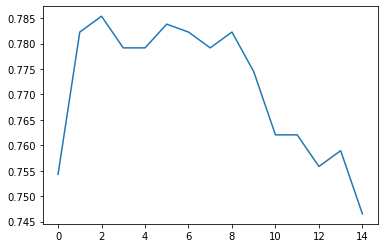

In [51]:
tree_accuracy_results['accuracy'].plot()

In [52]:
forest_accuracy_results = pd.DataFrame(columns=['number', 'max_depth','accuracy'])

best_forest_model = None
best_result = 0

for est in range(10, 61, 10):
    for depth in range (1, 11):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train,target_train)
        predictions = model.predict(features_valid) 
        result = accuracy_score(target_valid, predictions)
        forest_accuracy_results = forest_accuracy_results.append({'max_depth':depth,'number':est,'accuracy':result}, ignore_index=True)
        
        if result > best_result:
            best_forest_model = model 
            best_result = result

<AxesSubplot:>

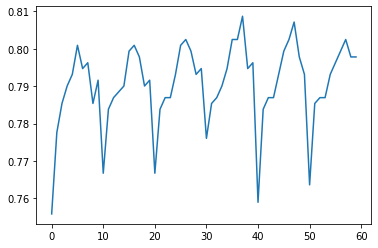

In [53]:
forest_accuracy_results['accuracy'].plot()

In [54]:
forest_accuracy_results.sort_values(by='accuracy', ascending=False).head(5)

,number,max_depth,accuracy
37,40.0,8.0,0.808709
47,50.0,8.0,0.807154
46,50.0,7.0,0.802488
36,40.0,7.0,0.802488
35,40.0,6.0,0.802488


Вывод

Лучше всего сработала модель с 40 деревьми максимальной глубины 8

In [55]:
logreg_accuracy_results = pd.DataFrame(columns=['solver', 'accuracy'])

solvers = ['lbfgs', 'sag', 'liblinear', 'saga'] #переберем возможные солверы, кроме newton-cg, так как он не сходится
best_logreg_model = None
best_result = 0

for solver in solvers:
    model = LogisticRegression(random_state=12345, solver= solver, max_iter=10000)
    model.fit(features_train,target_train)
    predictions = model.predict(features_valid) 
    result = accuracy_score(target_valid, predictions)
    logreg_accuracy_results = logreg_accuracy_results.append({'solver':solver,'accuracy':result}, ignore_index=True)
    if result > best_result:
        best_logreg_model = model 
        best_result = result

In [56]:
logreg_accuracy_results

,solver,accuracy
0,lbfgs,0.710731
1,sag,0.707621
2,liblinear,0.709176
3,saga,0.707621


Метод newton-cg не сходится даже при большом количестве итераций

Вывод

Лучшим методом для модели логистической регрессии оказался lbfgs

## Проверка на тестовой выборке

In [57]:
accuracy = pd.DataFrame(columns=['model','accuracy'])

models = [best_tree_model, best_forest_model,best_logreg_model]
dummy_predictions = DummyClassifier().fit(features_train,target_train).predict(features_test) 
random_predictions = numpy.random.randint(2, size=len(dummy_predictions))

for model in models:
    predictions = model.predict(features_test) 
    result = accuracy_score(target_test, predictions)
    adequacy_dummy = accuracy_score(random_predictions, predictions)
    adequacy_random = accuracy_score(random_predictions, predictions)
    accuracy = accuracy.append({'model': model, 'accuracy':result}, ignore_index=True)
    


In [58]:
accuracy

,model,accuracy
0,"DecisionTreeClassifier(max_depth=3, random_sta...",0.779160
1,"(DecisionTreeClassifier(max_depth=8, max_featu...",0.796267
2,"LogisticRegression(max_iter=10000, random_stat...",0.684292


Вывод

Лучше всего справилась модель случайного леса, хуже всех — логистическая регрессия

##  Проверка модели на адекватность

Сравним результаты с DummyClassifier и со случайной последовательностью

In [59]:
dummy_predictions = DummyClassifier().fit(features_train,target_train).predict(features_test) 
random_predictions = numpy.random.randint(2, size=len(dummy_predictions))

accuracy_dummy = accuracy_score(target_test, dummy_predictions)
accuracy_random = accuracy_score(random_predictions, predictions)

accuracy = accuracy.append({'model': "dummy", 'accuracy':accuracy_dummy}, ignore_index=True)
accuracy = accuracy.append({'model': "random", 'accuracy':accuracy_random}, ignore_index=True)  

In [60]:
accuracy

,model,accuracy
0,"DecisionTreeClassifier(max_depth=3, random_sta...",0.779160
1,"(DecisionTreeClassifier(max_depth=8, max_featu...",0.796267
2,"LogisticRegression(max_iter=10000, random_stat...",0.684292
3,dummy,0.684292
4,random,0.488336


Вывод

Логистическая регрессия работает не лучше Dummy Classifier, поэтому вменяемой ее назвать нельзя. Остальные адекватны. 